# Approximate q-learning

In this notebook you will teach a lasagne neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [77]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


In [78]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[2017-03-13 10:27:04,759] Making new env: CartPole-v0


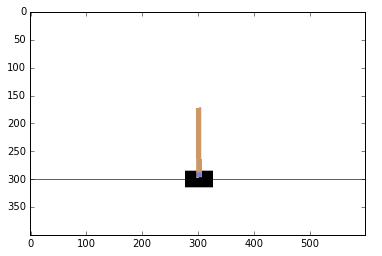

In [79]:
env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

In this section we will build and train naive Q-learning with theano/lasagne

First step is initializing input variables

In [80]:
import theano
import theano.tensor as T

#create input variables. We'll support multiple states at once

current_states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
rewards = T.vector("rewards[batch]")
next_states = T.matrix("next states[batch,units]")
is_end = T.ivector("vector[batch] where 1 means that session just ended")

In [81]:
import lasagne
from lasagne.layers import *

l_states = InputLayer((None,) + state_dim)
l = DenseLayer(l_states, num_units=32)
l_qvalues = DenseLayer(l, num_units=n_actions, nonlinearity=None)

#### Predicting Q-values for `current_states`

In [82]:
#get q-values for ALL actions in current_states
predicted_qvalues = get_output(l_qvalues, {l_states: current_states})

In [83]:
#compiling agent's "GetQValues" function
get_qvalues = theano.function(inputs=[current_states], outputs=predicted_qvalues)

In [84]:
#select q-values for chosen actions
predicted_qvalues_for_actions = predicted_qvalues[T.arange(actions.shape[0]), actions]

#### Loss function and `update`
Here we write a function similar to `agent.update`.

In [85]:
#predict q-values for next states
predicted_next_qvalues = get_output(l_qvalues, {l_states: next_states})


#Computing target q-values under 
gamma = 0.99
target_qvalues_for_actions = rewards + (1 - is_end) * gamma * predicted_next_qvalues.max()

#don't compute gradient over target q-values (consider constant)
target_qvalues_for_actions = theano.gradient.disconnected_grad(target_qvalues_for_actions)

In [86]:
#mean squared error loss function
loss = T.mean((predicted_qvalues_for_actions - target_qvalues_for_actions)**2)

In [87]:
#all network weights
all_weights = get_all_params(l_qvalues, trainable=True)

#network updates. Note the small learning rate (for stability)
updates = lasagne.updates.sgd(loss, all_weights, learning_rate=1e-4)

In [88]:
#Training function that resembles agent.update(state,action,reward,next_state) 
#with 1 more argument meaning is_end
train_step = theano.function([current_states, actions, rewards,next_states, is_end], updates=updates)

### Playing the game

In [89]:
epsilon = 0.25 #initial epsilon

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        
        #get action q-values from the network
        q_values = get_qvalues(s.reshape(1, -1).astype(np.float32))[0] 
        
        if np.random.random() < epsilon:
            a = np.random.choice(n_actions)
        else:
            a = np.argmax(q_values) 
        
        
        new_s, r, done, info = env.step(a)
        
        #train agent one step. Note that we use one-element arrays instead of scalars 
        #because that's what function accepts.
        train_step(s.reshape(1, -1).astype(np.float32), [a], [r], new_s.reshape(1, -1).astype(np.float32), [done])
        
        total_reward += r
        
        s = new_s
        if done: 
            break
            
    return total_reward  

In [ ]:
for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    epsilon *= 0.95
    
    print ("mean reward:%.3f\tepsilon:%.5f"%(np.mean(rewards),epsilon))

    if np.mean(rewards) > 300:
        print("You Win!")
        break
        
    assert epsilon != 0, "Please explore environment"

mean reward:83.490	epsilon:0.23750
mean reward:63.290	epsilon:0.22562
mean reward:13.970	epsilon:0.21434
mean reward:10.610	epsilon:0.20363
mean reward:10.760	epsilon:0.19345
mean reward:12.010	epsilon:0.18377
mean reward:21.870	epsilon:0.17458
mean reward:10.580	epsilon:0.16586
mean reward:13.210	epsilon:0.15756
mean reward:19.540	epsilon:0.14968
mean reward:10.780	epsilon:0.14220
mean reward:20.280	epsilon:0.13509
mean reward:10.170	epsilon:0.12834
mean reward:19.550	epsilon:0.12192
mean reward:10.480	epsilon:0.11582
mean reward:24.180	epsilon:0.11003
mean reward:11.790	epsilon:0.10453
mean reward:22.160	epsilon:0.09930
mean reward:11.990	epsilon:0.09434
mean reward:22.110	epsilon:0.08962
mean reward:12.580	epsilon:0.08514
mean reward:31.210	epsilon:0.08088
mean reward:18.930	epsilon:0.07684
mean reward:24.320	epsilon:0.07300
mean reward:17.840	epsilon:0.06935
mean reward:33.760	epsilon:0.06588
mean reward:33.150	epsilon:0.06259
mean reward:48.010	epsilon:0.05946
mean reward:45.510	e

### Video

In [ ]:
epsilon=0 #Don't forget to reset epsilon back to initial value if you want to go on training

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices